In [2]:
import gluoncv as gcv
import mxnet as mx
import matplotlib.pyplot as plt

In [4]:
image_url = 'https://raw.githubusercontent.com/zhreshold/mxnet-ssd/master/data/demo/dog.jpg'
image_filepath = 'dog.jpg'
im_fname=gcv.utils.download(url=image_url,path=image_filepath)

100%|██████████| 160/160 [00:00<00:00, 1725.03KB/s]


In [5]:
#  this loads the image is a multi dimensional array called an ND array. MXNet ND array is very similar to NumPy ND arrays.
image = mx.image.imread(im_fname)
# This in HWC layout as Height, Weight, Channel
print('shape', image.shape)
# After loading an image with imread, all values will be unsigned 8-bit integers.
print('data type: ', image.dtype)
print('minimum value:', image.min().asscalar())
print('maximum value:', image.max().asscalar())

shape (576, 768, 3)
data type:  <class 'numpy.uint8'>
minimum value: 0
maximum value: 255


## Visualize the image
> We can visualize the image using pyplot.
But we first need to convert the image from an MXNet ND array to a NumPy ND array with as NumPy. 

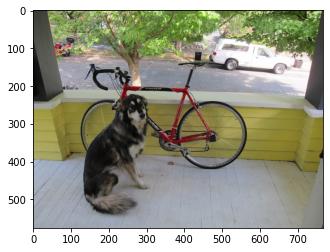

In [7]:
plt.imshow(image.asnumpy())
plt.show()

## Predict the image classification
* The network expects an input with four dimensions. It expects NCHW instead of HWC. N for the batch dimension, C for channel, H for height, and W for width.
* The neural network will expect 32-bit floats. And instead of values ranging from 0 to 255, our value should have an average value of 0 and a standard deviation of 1.
* GluonCV has a transform function to do all of this in a single step. Since we'll be using a neural network that was pre-trained on imagenet, we'll use the imagenet.transform_eval function. Other data sets have different transform functions.

### Transform and batch image

In [8]:
# Using this function, the height will be resized to 512 pixels while maintaining the aspect ratio of the image. 
image, chw_image = gcv.data.transforms.presets.yolo.transform_test(image, short=512)

In [9]:
# Our data layout is now NCHW. We have 32-bit floats, and the range of values looks centered around 0.
print('shape', image.shape)
print('data type: ', image.dtype)
print('minimum value:', image.min().asscalar())
print('maximum value:', image.max().asscalar())

shape (1, 3, 512, 683)
data type:  <class 'numpy.float32'>
minimum value: -2.117904
maximum value: 2.64


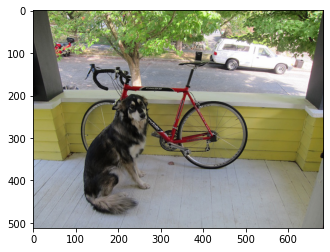

In [10]:
plt.imshow(chw_image)

You can see the effect of the resize.
Our short edge is now 512 pixels instead of 576 while the width
remains one-third times longer than the height.
When we generate some predictions from the network,
we'll overlay the detected objects onto this image.

### Load the Model

We can use the get_model function to load our pretrained model from the CV model zoo. Don't forget to set the pretrained argument to true.

We'll use the yolo3 network with a darknet53 backbone that has been trained on the coco dataset. Our network parameters are 237 megabytes and are stored in the.mxnet cache. 

In [11]:
network = gcv.model_zoo.get_model('yolo3_darknet53_coco', pretrained=True)

100%|██████████| 224190/224190 [01:38<00:00, 2270.56KB/s]


### Make Predictions

In [12]:
prediction = network(image)

In [14]:
type(prediction)

tuple

We're now ready to make a prediction. You can call network just like a function once again. Give network and image and a prediction will be returned. But this time our prediction isn't an MXNet ndarray. It's a tuple instead. When using detection models, you can expect three MXNet ndarrays to be returned.


In [15]:
# We can loop through the tuple and print out the shape of these arrays.
for index, array in enumerate(prediction):
    print(f'#{index+1} shape: {array.shape}')

#1 shape: (1, 100, 1)
#2 shape: (1, 100, 1)
#3 shape: (1, 100, 4)


The first array contains the object class indexes. The second array contains the object class probabilities. And the last array contains the object bounding box coordinates.

The shape of each of these arrays starts with a 1, 100 because we gave the network a batch of one image, so we get back a batch of one prediction. And our model can predict up to 100 objects in a single image. So for the first array, with a shape of 1, 100, 1, we have 1 image, 100 potential objects, and 1 class index per object. And for the last array, with shape 1, 100, 4, we have 1 image, 100 potential objects and 4 values for each object to define its bounding box.

Since we're only performing object detection on one image, let's remove the additional batch dimension for all of the arrays. We can then go ahead and unpack the tuple and give each array its own variable.

### Unpack prediction

In [16]:
prediction = [array[0] for array in prediction]

In [20]:
class_indices, probabilities, bounding_boxes = prediction

### 1. Object classes

With object detection models, the top-one class is chosen. Although our model can potentially detect 100 objects per image, let's just take a look at the class indexes for the first ten objects.

In [21]:
# Get top-k
k = 10
print(class_indices[:k])


[[16.]
 [ 1.]
 [ 7.]
 [ 2.]
 [13.]
 [ 0.]
 [58.]
 [-1.]
 [-1.]
 [-1.]]
<NDArray 10x1 @cpu(0)>


Our first detected object has a predicted class of 16, and we see more objects with classes 1, 7, 2, 13 and 0. After this, we have a number of objects with a class index of -1. -1 is a special class index that is used to indicate there is no detected object. We have six detected objects in total, with the remaining 94 potential objects being padded with -1 values.

In [26]:
class_index = 16
assert class_index > -1
print(network.classes[class_index])

dog


### 2. Object probabilities

It's the same as for object class indexes, but instead of the object class index, we have the associated object class probability. We can interpret this as our confidence that the class index is correct. 

In [27]:
print(probabilities[:k])


[[ 0.9922735 ]
 [ 0.9646551 ]
 [ 0.6890225 ]
 [ 0.23493573]
 [ 0.01805793]
 [ 0.01063585]
 [ 0.01027776]
 [-1.        ]
 [-1.        ]
 [-1.        ]]
<NDArray 10x1 @cpu(0)>


Using a confidence threshold of 50%, we can see that three objects have been detected. You'll want to experiment with the threshold for your own application. You can lower the threshold to get more objects but you're likely to see more detection errors.

Our model is very confident in two of its detections, with probability scores in the high 90s. These could be the two foreground objects.

### 3. Object Bounding Box


You'll notice there are four values used to define the bounding box of each object. We specify the coordinates for the top-left corner, and the bottom-right corner of the bounding box, giving us four values in total. 

In [28]:
print(bounding_boxes[:k])


[[116.383095 201.52266  281.88876  482.33264 ]
 [ 94.03955  107.238785 504.92346  376.52264 ]
 [417.18365   69.68815  614.6805   149.04834 ]
 [417.18365   69.68815  614.6805   149.04834 ]
 [ 91.04439  124.79434  504.3833   403.57736 ]
 [532.793     92.20426  547.2879   104.81126 ]
 [ 51.13082   68.55553   95.09498  111.617294]
 [ -1.        -1.        -1.        -1.      ]
 [ -1.        -1.        -1.        -1.      ]
 [ -1.        -1.        -1.        -1.      ]]
<NDArray 10x4 @cpu(0)>


It's hard to interpret the bounding boxes from a table. CV comes with a bounding box plot function out of the box. We can provide the resized image from earlier. And also each of the network outputs. Optionally, we can provide the class labels to add annotations to our plot.

<AxesSubplot:>

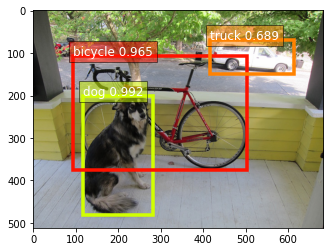

In [29]:
gcv.utils.viz.plot_bbox(chw_image,
                        bounding_boxes,
                        probabilities,
                        class_indices,
                        class_names=network.classes)

We can see that our network has done a good job of detecting the objects. We have detected a dog, a bike and a truck. Our network missed the tree in the background. But that's because we're using a model that's been pretrained on coco. And coco doesn't have an object class for trees.